Tiffany Kashima
STP494 (HW3)

- Demonstrate KNN and k fold cross validation with train/validation/test splits
- Demonstrate choice of kernel for KNN hyperparameter 
- Demonstrate basic unconstrained for IID Poisson data and constrained optimization mathematics and intuition 

K-Nearest Neighbors regression is a supervised machine learning algorithm.  It is a non-parametric method that in contrast to linear regression does not rely as heavily on assumptions of the form of the relationship between target and features as heavily as linear regression.  In terms of bias-variance trade-off, the higher number of K generally lends to a more bias but less variance, while a low number for K will have more variance and less bias.  Optimization metrics for the K that minimizes both bias and variance can be done using cross validation.  

In [137]:
# import

import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
import seaborn as sns; sns.set()
import plotly_express as px
import plotly.graph_objects as go

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# algorithms
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import SCORERS
from math import sqrt

# validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

In [5]:
# Using the used cars data, check basic structure, types, and stats

# Read in data
usedcar = pd.read_csv('/Users/tk/ASU/STP494/data/susedcars.csv')

In [52]:
# glimpse data
usedcar.head(10)

,price,trim,isOneOwner,mileage,year,color,displacement
0,43995,550,f,36858.0,2008,Silver,5.5
1,44995,550,f,46883.0,2012,Black,4.6
2,25999,550,f,108759.0,2007,White,5.5
3,33880,550,f,35187.0,2007,Black,5.5
4,34895,550,f,48153.0,2007,Black,5.5
5,5995,500,f,121748.0,2002,other,other
6,21900,550,f,115280.0,2007,other,5.5
7,41995,other,f,36370.0,2007,Black,5.5
8,39882,other,f,76996.0,2008,Black,other
9,47995,550,f,43568.0,2011,Black,5.5


In [7]:
usedcar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         1000 non-null   int64  
 1   trim          1000 non-null   object 
 2   isOneOwner    1000 non-null   object 
 3   mileage       1000 non-null   float64
 4   year          1000 non-null   int64  
 5   color         1000 non-null   object 
 6   displacement  1000 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 54.8+ KB


In [8]:
# dimensions of dataset
usedcar.shape

(1000, 7)

In [9]:
# select categorical variables
usedcar.select_dtypes(exclude=['int64','float64']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   trim          1000 non-null   object
 1   isOneOwner    1000 non-null   object
 2   color         1000 non-null   object
 3   displacement  1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB


In [10]:
# explore object dtype variables
print(usedcar.trim.unique())
print(usedcar.isOneOwner.unique())
print(usedcar.color.unique())
print(usedcar.displacement.unique())

['550' '500' 'other' '430']
['f' 't']
['Silver' 'Black' 'White' 'other']
['5.5' '4.6' 'other']


In [11]:
# frequencies for categorical variables
print(usedcar.trim.value_counts())
print(usedcar.isOneOwner.value_counts())
print(usedcar.color.value_counts())
print(usedcar.displacement.value_counts())

550      591
430      143
other    139
500      127
Name: trim, dtype: int64
f    841
t    159
Name: isOneOwner, dtype: int64
Black     415
other     227
Silver    213
White     145
Name: color, dtype: int64
5.5      476
other    387
4.6      137
Name: displacement, dtype: int64


In [12]:
# basic summary stats for variables of interest (mileage and price)
usedcar.mileage.describe()

count      1000.000000
mean      73652.408000
std       42887.422189
min        1997.000000
25%       40132.750000
50%       67919.500000
75%      100138.250000
max      255419.000000
Name: mileage, dtype: float64

In [13]:
usedcar.price.describe()

count     1000.000000
mean     30583.318000
std      18411.018385
min        995.000000
25%      12995.000000
50%      29800.000000
75%      43992.000000
max      79995.000000
Name: price, dtype: float64

In [14]:
# Preview some random rows (by index)
usedcar.sample(2, random_state=123).T


,131,203
price,73995,25000
trim,other,550
isOneOwner,f,f
mileage,4171.0,129481.0
year,2010,2007
color,other,Silver
displacement,5.5,5.5


In [15]:
# check distribution (by quantile) in the variables of interest (mileage and price)
varinterest = ['mileage', 'price']
usedcar[varinterest].quantile(np.arange(0.0, 1.1, 0.1))

,mileage,price
0.0,1997.0,995.0
0.1,23079.3,7976.8
0.2,35157.4,10999.0
0.3,45382.1,15995.0
0.4,58053.8,24995.0
0.5,67919.5,29800.0
0.6,79940.8,34895.0
0.7,92041.4,39900.0
0.8,107458.4,47800.0
0.9,128581.3,56999.0


In [16]:
# subset just the varibales of interest
ucdf = usedcar.loc[:,varinterest]
ucdf.head()

,mileage,price
0,36858.0,43995
1,46883.0,44995
2,108759.0,25999
3,35187.0,33880
4,48153.0,34895


In [17]:
# measure skew
# data demonstrates positive skew, not unexpected
ucdf.skew()

mileage    0.844610
price      0.414794
dtype: float64

In [18]:
# measure kurtosis
ucdf.kurtosis()

mileage    0.848851
price     -0.668385
dtype: float64

In [19]:
# for identifying outliers
firstquant, thridquant = ucdf.mileage.quantile(.25), ucdf.mileage.quantile(.75)
print(firstquant,thridquant, sep='<-->')

40132.75<-->100138.25


In [83]:
# store into y and X variables
X = ucdf['mileage'].values.reshape(-1,1)
y = ucdf['price']

Text(0, 0.5, 'Price')

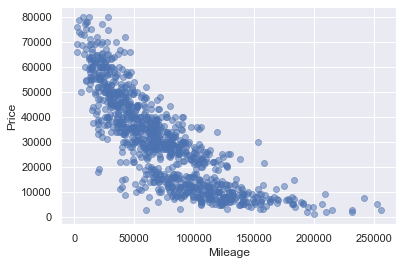

In [21]:
# Scatter plot of data (y: price, x: mileage)

# the basic shape suggests a inverse proportional relationship or an inverse square relationship even with the noise
plt.scatter(X,y, alpha=.5)
plt.xlabel('Mileage')
plt.ylabel('Price')

Text(0.5, 1.0, 'Distribution of Mileage')

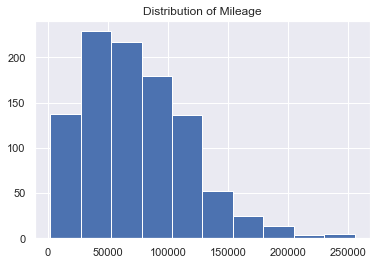

In [22]:
#visually show skew and kutosis for mileage

plt.hist(X)
plt.title('Distribution of Mileage')

In [23]:
# With basic EDA accomplished (which should be done before modeling on any dataset), move on to KNN and cross validation

In [84]:
# before demonstrating cross validation, will use a test/train split and "eyeball" the best K based on graphical performance metrics (this will be the basis of comparison)

# split the data into a train/test split 

rdm = 123
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=rdm, test_size=.2)

In [85]:
# sorting and reshaping for graphing results
Xtestsort = np.sort(Xtest[:,0])
Xtestsort = Xtestsort.reshape(-1,1)

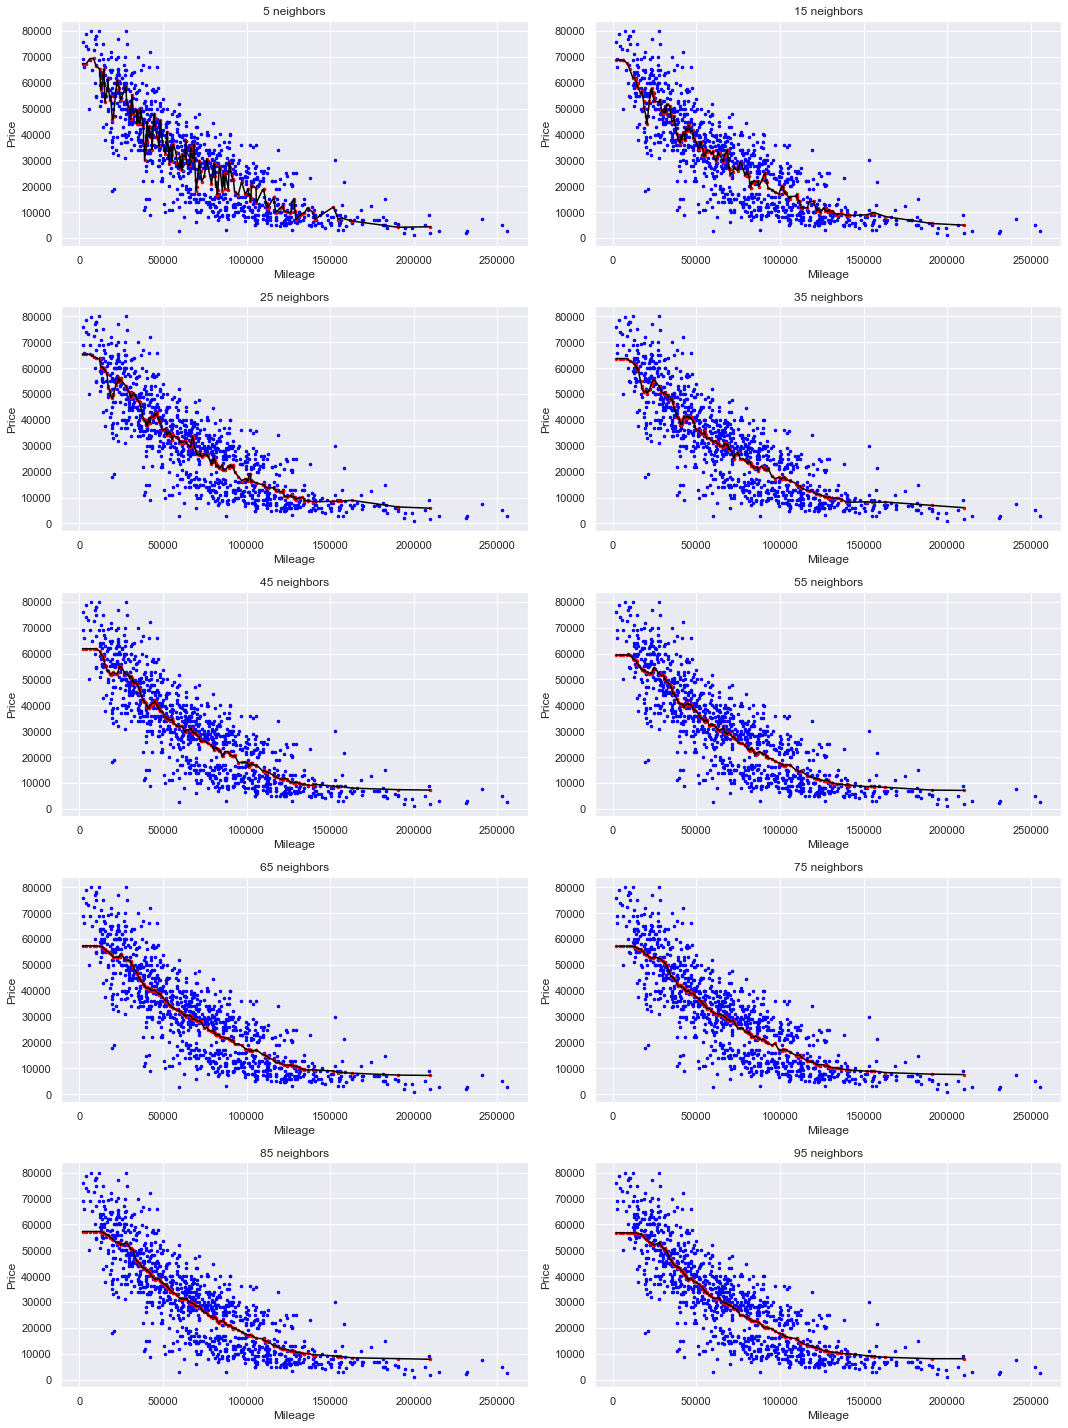

In [86]:
# Demonstrating manually choosing ideal hyperparamter for knn model with rudimentary look thorugh a list of k vals

fig, axes = plt.subplots(5,2,figsize=(15, 20))

for n_neighbors, ax in zip([5, 15, 25, 35, 45, 55, 65, 75, 85, 95], axes.ravel()):
    knmodel = KNeighborsRegressor(n_neighbors=n_neighbors)
    knmodel.fit(Xtrain,ytrain)
    yhat = knmodel.predict(Xtestsort)
    ax.plot(X, y, '.', c='blue',   
             markersize=5)
    ax.plot(Xtestsort, yhat, '.', c='red', markersize=5)
    ax.plot(Xtestsort, yhat, c='black')
    ax.set_title("{} neighbors".format(n_neighbors))
    ax.set_xlabel("Mileage")
    ax.set_ylabel("Price")

fig.tight_layout()


- "eyeballing" the best k from these selections without other metrics is difficult.  Clearly we do not want to caputure too much noise, which is apparent in k=5,15, but 
need to also caputure enough signal, which is lacking in k=85,95.  But how do we quantitatively know our choice is optimal?

In [87]:
# Taking this a step further: Will now look at the training/test RMSE versus model complexity.  Will loop over n_neighbors in range of 5-95 to generate RMSE metrics for each iteration.  

#Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=rdm, test_size=.2)

kval = np.arange(5,96,1)
modcx = np.log(1/kval)

rmse_train = {}
rmse_test = {}

for k in kval:
    knmodel = KNeighborsRegressor(n_neighbors=k)
    knmodel.fit(Xtrain,ytrain)
    yhat = knmodel.predict(Xtrain)
    error = sqrt(mean_squared_error(ytrain,yhat))
    rmse_train[k] = error
    yhat = knmodel.predict(Xtest)
    error = sqrt(mean_squared_error(ytest,yhat))
    rmse_test[k] = error
    k+=1

print('The best k value from test performance is:', min(rmse_test, key=rmse_test.get))

The best k value from test performance is: 18


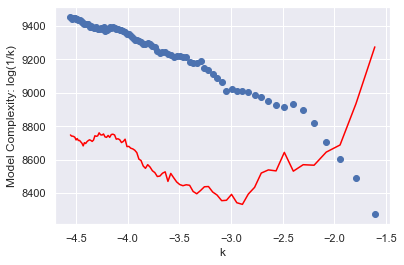

In [88]:
# plotting test and train performance to evaluate optimal model complexity as well as fit performance
# note the noise and gaps

plt.scatter(modcx,rmse_train.values())
plt.plot(modcx,rmse_test.values(), c='red')
plt.xlabel('Model Complexity: log(1/k)')
plt.ylabel('RMSE')
plt.show()

In [90]:
%%capture output
# now lets compare to a 5-fold cross validation to find the best value for n_neighbors hyerparameter (k)
# ideally, it would prudent to perform this several times and average the results (also, ideally we would use gridserachCV if computation resource is of no issue)
# performing one time to demonstrate concept using neg_mean_squared_error so we have the same metrics to compare

mod = KNeighborsRegressor()
trainS, testS = validation_curve(mod,X,y,'n_neighbors',kval,cv=5,scoring='neg_mean_squared_error')

rmsetr = np.sqrt(-trainS.mean(axis=1))
rmsete = np.sqrt(-testS.mean(axis=1))

Text(0.5, 0, 'Model Complexity: log(1/k)')

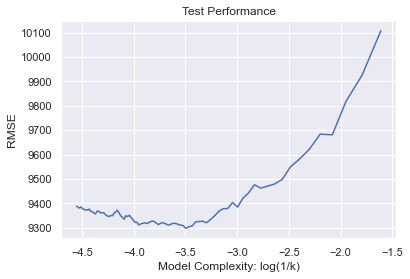

In [91]:
# plot of the model complxity versus test RMSE for each choice of hyperparamter using 5-fold cross validation
# We have a nice global min in our graph domain
plt.plot(modcx,rmsete)
plt.title('Test Performance')
plt.ylabel('RMSE')
plt.xlabel('Model Complexity: log(1/k)')

In [92]:
minr = min(rmsete)
print('The minimum RMSE for validation curve for test data is: ',minr)
print('The location of the min RMSE is: ',np.where(rmsete == minr))
print('The k number of neighbors for which test validation curve is minimized by RMSE is:',(kval[28]))


The minimum RMSE for validation curve for test data is:  9297.227908434916
The location of the min RMSE is:  (array([28]),)
The k number of neighbors for which test validation curve is minimized by RMSE is: 33


Text(0.5, 0, 'Model Complexity: log(1/k)')

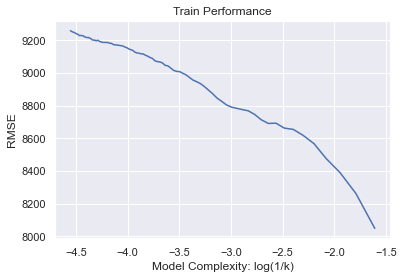

In [93]:
# train performance 
plt.plot(modcx,rmsetr)
plt.title('Train Performance')
plt.ylabel('RMSE')
plt.xlabel('Model Complexity: log(1/k)')

In [95]:
# run prediction for a car with 100000 miles on it (xnew) for k=33 and k=18, train the learner on ALL data (as instructed) for comparison
# THe difference between the two hyperparameters when comparing predcitions is approximately $1000

xnew = [[100000]]
km1 = KNeighborsRegressor(n_neighbors=33)
km1.fit(X,y)
pred1 = km1.predict(xnew)
km2 = KNeighborsRegressor(n_neighbors=18)
km2.fit(X,y)
pred2 = km2.predict(xnew)
print('The prediction for k=33 is: ',pred1)
print('The prediciton for k=18 is:',pred2)

The prediction for k=33 is:  [17751.66666667]
The prediciton for k=18 is: [18755.5]


In [145]:
# get RMSE for n_neigbors = 33 (from our validation curve object)
# use test, train split so it can be fairly compared to the next problem with two variables
km1.fit(Xtrain,ytrain)
yhat = km1.predict(Xtest)
error = sqrt(mean_squared_error(ytest,yhat))
error

8451.034137920273

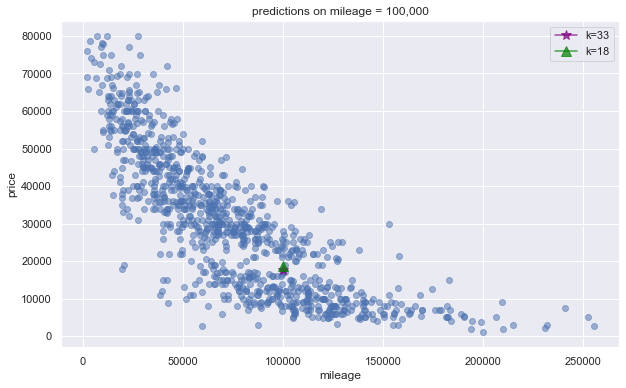

In [97]:
# compare k=33 and k=20 on the prediction of a used car with 100,000 miles on it.

fig = plt.figure(figsize=(10,6))

plt.scatter(X,y,alpha=.5)
plt.plot(xnew,pred1,marker='*', c='purple', markersize=10, alpha=.7,label='k=33')
plt.plot(xnew,pred2,marker="^", c='green', markersize=10, alpha=.7, label='k=18')
plt.xlabel("mileage")
plt.ylabel("price")
plt.title("predictions on mileage = 100,000")
plt.legend()


- 5 fold cross validation resulted in the ideal k (n_neighbors) as 33.  This resulted in a RMSE of approximately $9297.  While the running a single KNN Regressor once for each value of k in the same range yielded a smaller hyperparameter, it was just the result of a single iteration of the learner.  This may not be a reliable result as it would be ideal to have a repeatble results for confirmation.  Using a variety of validation techniques could better confirm the result of k =33 vs k=18.  It is much more robust to run a learner through validation several times to make sure the results are stable.

In [98]:
# Demonstrate the importance of scale when more than one feature is involved as KNN is very sensitive to the relative magnitude of the features
# Note, the type of scaling should only be explored in train data.  The selected scaler should then only be applied to the test data to prevent information leak
# In this example, we are using a simple min/max scaler (chosen a priori)

# taking a glance at our additional data
multvar = ['mileage', 'year', 'price']
ucdf2 = usedcar.loc[:,multvar]
ucdf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mileage  1000 non-null   float64
 1   year     1000 non-null   int64  
 2   price    1000 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [99]:
ucdf2.head()

,mileage,year,price
0,36858.0,2008,43995
1,46883.0,2012,44995
2,108759.0,2007,25999
3,35187.0,2007,33880
4,48153.0,2007,34895


(array([ 17.,  17.,  10.,  80.,  93.,  74., 222., 185., 156., 146.]),
 array([1994. , 1995.9, 1997.8, 1999.7, 2001.6, 2003.5, 2005.4, 2007.3,
        2009.2, 2011.1, 2013. ]),
 <BarContainer object of 10 artists>)

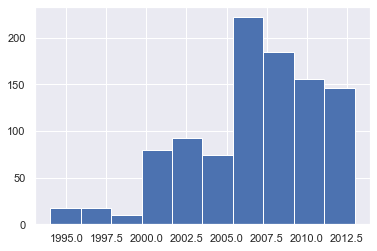

In [100]:
plt.hist(ucdf2['year'])

<AxesSubplot:>

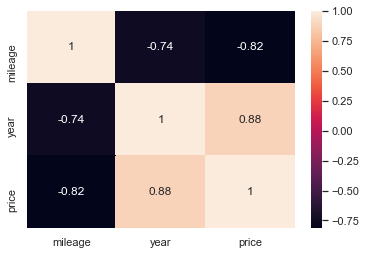

In [101]:
# Look at correlation matrix for the target (price) and features(mileage and year)
# Newer year is positively correlated with price with greater mileage is inversely related to price
corrMatrix = ucdf2.corr()
sns.heatmap(corrMatrix, annot=True)

In [102]:
ucdf2['year'].describe()

count    1000.000000
mean     2006.939000
std         4.194624
min      1994.000000
25%      2004.000000
50%      2007.000000
75%      2010.000000
max      2013.000000
Name: year, dtype: float64

In [103]:
# Store to target and feature variables
y = ucdf2[['price']].to_numpy()
X = ucdf2[['mileage','year']].to_numpy()

In [104]:
# Make a test/train (80/20) split
trainX, testX, trainy, testy = train_test_split(X, y, test_size=.2, random_state=rdm)

In [105]:
# Scale feature train/test data using normalization (min/max), values transformed to a number between 0 and 1
# Note, if we were exploring different scaling options at this point, we would only be doing such exploration on train data to preventy information leak/bias
# We were not asked to also scale our target-- this is genrerally not necessary but might come up in some gradient descent and/or nueral network situations
# Additionaly, if the target is scaled and we are using MSE/RMSE it will effect the scale of those metrics as well

scaler = MinMaxScaler()
scaler.fit(trainX)
Xt = scaler.transform(trainX)
scaler.fit(testX)
X1t = scaler.transform(testX)

(array([113., 177., 175., 142., 110.,  41.,  21.,  13.,   3.,   5.]),
 array([  2325. ,  27634.4,  52943.8,  78253.2, 103562.6, 128872. ,
        154181.4, 179490.8, 204800.2, 230109.6, 255419. ]),
 <BarContainer object of 10 artists>)

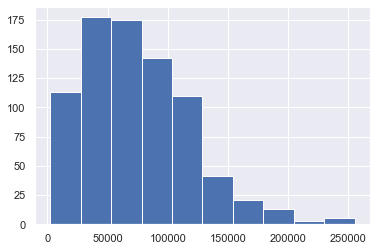

In [106]:
# check distribution of scaled variables
plt.hist(trainX[:,0])

(array([ 13.,  14.,  10.,  66.,  72.,  59., 170., 154., 127., 115.]),
 array([1994. , 1995.9, 1997.8, 1999.7, 2001.6, 2003.5, 2005.4, 2007.3,
        2009.2, 2011.1, 2013. ]),
 <BarContainer object of 10 artists>)

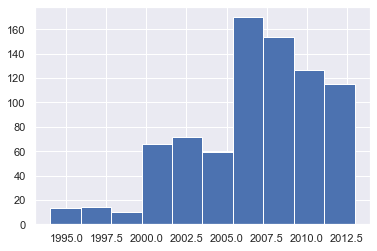

In [107]:
# distribution is maintained for both variables
plt.hist(trainX[:,1])

In [109]:
# performing k selection on our original training set only(i.e. we are essentially doing a train/validation split here, still 'blind' to test data used for final eval)
# A consideration here would be the size of data set and being mindful about sparcity

km = KNeighborsRegressor()
kvals = np.arange(2,100,1)
modx = np.log(1/kvals)

train_scores, test_scores = validation_curve(km,Xt,trainy,'n_neighbors',kvals,cv=5,scoring='neg_mean_squared_error')

train_RMSE = np.sqrt(-train_scores.mean(axis=1))
test_RMSE = np.sqrt(-test_scores.mean(axis=1))


plt.title("Validation Curve with KNN")
plt.xlabel('Model Complexity')
plt.ylabel("Score")
lw = 2
plt.plot(modx, train_RMSE, label="Training RMSE", color="darkorange", lw=lw)
plt.plot(modx, test_RMSE, label="Cross-validation RMSE", color="navy", lw=lw)
plt.legend(loc="best")
plt.show()



In [46]:
# best RMSE
cvmin = min(test_RMSE)
cvmin

5564.496194213667

In [47]:
np.where(test_RMSE == cvmin)

(array([20]),)

In [48]:
# Best k
kvals[20]

22

In [111]:
# use full training/test set for prediction using optimized hyperparamter and get RMSE

xnew = [[75000,2008]]
km = KNeighborsRegressor(n_neighbors=22)
km.fit(trainX,trainy)
yhat = km.predict(testX)
error = sqrt(mean_squared_error(testy,yhat))
error

8354.743288403539

In [112]:
# Prediction for car with 75000 miles and 2008 year
pred = km.predict(xnew)
pred

array([[27157.95454545]])

In [144]:
# interactive plot for dataset with prediction
zdata = y.reshape(-1)
ydata = X[:,0].reshape(-1)
xdata = X[:,1].reshape(-1)

fig = px.scatter_3d(x=xdata, y=ydata, z=zdata, labels={'x':'year', 'y':'mileage', 'z':'price'}, hover_data=[], color=zdata, opacity=.5)
fig.add_scatter3d(x=[2008], y=[70000], z=[27157.95], mode='markers', marker_symbol= 'diamond')
fig.update_traces(marker_size = 4) 
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",)
fig.show()


- Adding year feature and also using 5-fold CV to optimize the hyperparamter is only slightly improved.  The RMSE improvement is about $100, which is not significant enough to justify not using the more parsimonious model.  

/Users/tk/opt/miniconda3/envs/data-science-env/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning:

Pass param_name=n_neighbors, param_range=[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



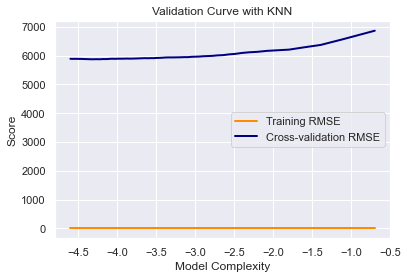

In [148]:
# Tuning our multivariable model using the weights hyperparamter.  Originally used the defauly "uniform" paramter and will now use the "distance" paramter (weighs points on the inverse of their distance)

km = KNeighborsRegressor(weights='distance')
kvals = np.arange(2,100,1)
modx = np.log(1/kvals)

train_scores, test_scores = validation_curve(km,Xt,trainy,'n_neighbors',kvals,cv=5,scoring='neg_mean_squared_error')

train_RMSE = np.sqrt(-train_scores.mean(axis=1))
test_RMSE = np.sqrt(-test_scores.mean(axis=1))


plt.title("Validation Curve with KNN")
plt.xlabel('Model Complexity')
plt.ylabel("Score")
lw = 2
plt.plot(modx, train_RMSE, label="Training RMSE", color="darkorange", lw=lw)
plt.plot(modx, test_RMSE, label="Cross-validation RMSE", color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

- Without going further, we can already see that setting the weights='distance' when trying to find the best hyperparamter for n_neighbors struggled to learn from our dataset and is extremely underfit
- However, we can test using the same hyperparamter for n_neighbors from before (k=22) with the weight='distance] just to see the difference in RMSE directly

In [149]:
xnew = [[75000,2008]]
km = KNeighborsRegressor(n_neighbors=22, weights='distance')
km.fit(trainX,trainy)
yhat = km.predict(testX)
error = sqrt(mean_squared_error(testy,yhat))
error

9285.891993865256

In [150]:
# Prediction for car with 75000 miles and 2008 year
pred = km.predict(xnew)
pred

array([[26279.91099546]])

- In comparison, the RMSE is approx $1000 higher when using the distance based weights.

### Basic Optimization:

Given $Y_i$ ~ $Poisson(\lambda), iid$ for $Y_i=y_i$, the MLE of paramter $\lambda$:

\begin{equation}
\begin{split}
    P(Y=y|\lambda) = \frac{e^{-\lambda}\lambda^y}{y!},\: \mathrm{for}\: y = 0,1,\dots,n \\
    \text{since } Y \text{ is iid},\:\text{it follows that } \: L(\lambda;y_i) = \prod_{i=1}^n \frac{e^{-\lambda}\lambda^{y_i}}{y_i!} \\
    \text{taking the natural log of the likelihood function, }L:
    \sum_{i=1}^nln\left(\frac{e^{-\lambda}\lambda^{y_i}}{y_i!}\right) & =\sum_{i=1}^n\left(ln(e^{-\lambda})+ln(\lambda^{y_i})-ln(y_i)\right) \\
    & = \sum_{i=1}^n\left(-\lambda+y_iln(\lambda)-ln(y_i!)\right) \\
    & = ln(\lambda)\sum_{i=1}^n y_i-n\lambda-\sum_{i=1}^nln(y_i!) \\
    \frac{\mathrm d}{\mathrm dx} \left(ln(\lambda)\sum_{i=1}^n y_i-n\lambda-\sum_{i=1}^nln(y_i!)\right) & = \frac{1}{\lambda}\sum_{i=1}^n y_i-n \\
    0 & =\frac{1}{\lambda}\sum_{i=1}^n y_i-n \\
    & \lambda=\frac{1}{n}\sum_{i=1}^n y_i \\
    & \text{which is the sample mean, } \overline{Y}
    
\end{split}    
\end{equation}


### Constrained Optimization:

Given the function: $f(x)=(x_1-a_1)^2+(x_2-a_2)^2$, with the constraint: $g(x)=x_1^2+x_2^2-1$, $\text{such that }g(x)\leq0$

Minimizing $f(x)$ with unknowns $(a_1,a_2)$ :  $g$ is a circle with a radius of 1. For $g$ equals 1 or a number less than 1, then $(x_1^2+x_2^2)\geq1$

Using Lagrange multiplier, $\lambda$:

Solve $\bigtriangleup f=\lambda\bigtriangleup g$:
\begin{equation}
\begin{split}
    \frac{\partial f}{\partial x_1} & =\lambda\frac{\partial g}{\partial x_1} \\
    \frac{\partial f}{\partial x_2} & =\lambda\frac{\partial g}{\partial x_2}
\end{split}
\end{equation}
gives the following:
\begin{equation}
\begin{split}
    \frac{\partial f}{\partial x_1} & = 2(x_1-a_1), \lambda\frac{\partial g}{\partial x_1} = 2\lambda x_1 \\
    \frac{\partial f}{\partial x_2} & = 2(x_2-a_2), \lambda\frac{\partial g}{\partial x_2} = 2\lambda x_2
\end{split}
\end{equation} 
solving the system of equations:
\begin{equation}
\begin{split}
    2(x_1-a_1) & = 2\lambda x_1 \\
    2(x_2-a_2) & = 2\lambda x_2, \\
    \frac{(x_1-a_1)}{x_1} & = \lambda \\
    \frac{(x_2-a_2)}{x_2} & = \lambda, \\
    \frac{(x_1-a_1)}{x_1} & = \frac{(x_2-a_2)}{x_2}, \\
    xy-a_1y & = xy-a_2x \\
    y & = x\frac{a_2}{a_1}
\end{split}
\end{equation}
Note: This makes sense as this is the slope equation of the line from $(0,0)$ to $a_1,a_2$, given the contraint and minimized $f$.
Intuitively, we are minimizing the distance between $a_1,a_2$ and $x_1,x_2$ given $f$ constrained by $g\leq1$ (the point must lie in the circle)

One additonal observation of many possible statements of the norm: If $\parallel\mathbf{a}\parallel$ is zero then the min of $f$ is equal to the max of $f$ (by definition $a_1,a_2$ must be at the origin given our problem and considering the Eucladian norm).


    
